## Определение перспективного тарифа для телеком компании

### Описание задачи

* Данный проект направлен на изучение данных о 500 пользователях телеком компании для определения одного из двух пользовательских тарифов (Smart или Ultra)


Данные: 5 файлов
* С информацией о 500 пользователях (имя, фамилия, город, тариф, возраст дата регистраици, дата ухода)
* С длительностью каждого звонка пользователя и времени совершения звонка (год, месяц, день),
* С объемом использованного интернет трафика по пользователям и времени захода в интернет(год, месяц, день)
* С количеством отправленных сообщений по пользователям и времени отправки сообщения (год, месяц, день)
* С описанием тарифов (плата за тариф, объем интернета, звонков и сообщений в тарифе, плата за превышение длительности звонков, интернет трафика и количества сообщений)

### Оглавление
* [Изучение и предобработка файлов](#1-bullet)
* [Объединение файлов](#2-bullet)
* [Расчет значений](#3-bullet)
* [Визуализация](#4-bullet)
* [Проверка гипотез](#5-bullet)
* [Общий вывод](#6-bullet)

### 1. Изучение и предобработка файлов. <a class="anchor" id="1-bullet"></a>

Подключение библиотек

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st

Откроем файлы

In [2]:
data_calls = pd.read_csv('/datasets/calls.csv', sep=',')
data_internet = pd.read_csv('/datasets/internet.csv', sep=',')
data_messages = pd.read_csv('/datasets/messages.csv', sep=',')
data_tariffs = pd.read_csv('/datasets/tariffs.csv', sep=',')
data_users = pd.read_csv('/datasets/users.csv', sep=',')

#### Посмотрим на каждый файл. Сначала изучим data_calls

In [3]:
display(data_calls.head(10))
data_calls.info()
data_calls.groupby('duration')['duration'].count()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


duration
0.00     39613
0.01       101
0.02        84
0.03        80
0.04        85
         ...  
35.95        1
36.12        1
36.47        1
37.35        1
38.00        1
Name: duration, Length: 2871, dtype: int64

В файле нет пропусков, но есть нулевая длительность звонков. Посмотрим, какой процент составляют нулевые значения

In [4]:
round(data_calls.query('duration == 0')['duration'].count()/len(data_calls),3)

0.196

Сделаем отдельный столбец с месяцем, чтобы подробнее рассмотреть причину нулевых значений

In [5]:
data_calls['call_date'] = pd.to_datetime(data_calls['call_date'], format = '%Y-%m-%d')
data_calls['month'] = data_calls['call_date'].dt.month
data_calls.query('duration == 0').groupby('month')['duration'].count()

month
1      312
2      623
3     1304
4     1768
5     2531
6     2883
7     3518
8     4231
9     4615
10    5389
11    5837
12    6602
Name: duration, dtype: int64

Пропуски распределены неравномерно по месяцам. Количество пропусков увеличивается каждый месяц. Пока не поятно, с чем это связано. Посмотрим группировку по пользователям

In [6]:
data_calls.query('duration == 0').groupby('user_id')['duration'].count().sort_values(ascending = False)

user_id
1377    336
1168    308
1453    295
1375    290
1196    262
       ... 
1206      6
1442      5
1406      5
1084      5
1424      5
Name: duration, Length: 492, dtype: int64

Посмотрим процент пропусков у каждого пользователя. Если этот процент отличается, то не будем учитывать звонки конкретных пользователей

Text(0, 0.5, '% звонков с нулевой длительностью')

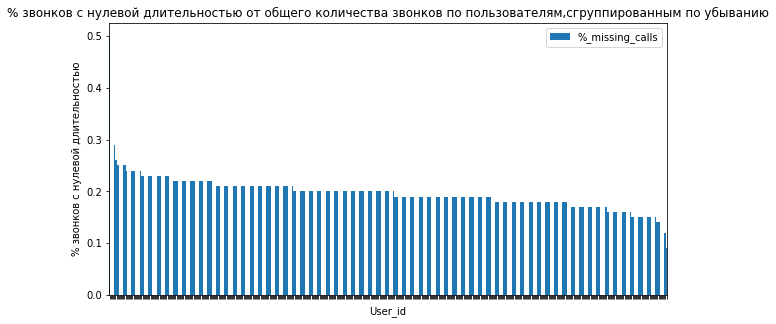

In [7]:
grouped_calls = pd.pivot_table(data_calls, index = 'user_id', values = ['id'], aggfunc = 'count' )
missing_calls = pd.pivot_table(data_calls.query('duration == 0'), index = 'user_id', values = 'id', aggfunc = 'count' )
grouped_calls = grouped_calls.join(missing_calls, how = 'outer', rsuffix = '_x')
grouped_calls.columns = ['total_number_of_calls', 'number_of_missing_calls']
grouped_calls ['%_missing_calls'] = round(grouped_calls['number_of_missing_calls']/ grouped_calls['total_number_of_calls'],2)
missing_calls_plot = grouped_calls.sort_values('%_missing_calls', ascending = False).\
plot(title = '% звонков с нулевой длительностью от общего количества звонков по пользователям,сгруппированным по убыванию'\
     ,y= '%_missing_calls',kind = 'bar', figsize = (10,5))
missing_calls_plot.set_xticklabels('')
plt.xlabel('User_id')
plt.ylabel('% звонков с нулевой длительностью')

Процент пропусков примерно одинаковый у всех пользователей - от 15% до 20%. Отсюда вывод, что пропуски связаны не с конкретным пользователем, а присуще всей выборке. Гипотеза, что это ошибка при сборе данных, пропуски на самом деле - не звонки.
* 1) При исключении пропусков общее количество секунд разговора не изменится, уменьшится количество звонков в среднем на 20%, среднее количество секунд разговора для пользователя увеличится, медиана увеличится незначительно.
* 2) При замене 0 на None общее количетво секунд разговора не изменится, количество звонков не изменится, среднее количество секунд разговора для пользователя увеличится, медиана увеличится незначительно.
* 3) При оставлении пропусков среднее количество секунд разговора будет ниже реальных
* Самым оптимальным вариантом является вариант 1) и 2), так как для дальнейшего анализа необходимо может потребоваться расчет среднего и медианного времени разговора. В варианте 3 среднее будет отличаться от реального и отличаться от медианы. Выберем вариант 1, чтобы усокорить работу с файлами.

In [8]:
print('Среднее значение длительности звонка перед удалением равно', data_calls['duration'].mean())
print('Медианное значение длительности звонка перед удалением равно', data_calls['duration'].median())
data_calls = data_calls.drop(data_calls[data_calls['duration'] == 0].index)
data_calls.head(10)
print('Среднее значение длительности звонка после удаления равно', data_calls['duration'].mean())
print('Медианное значение длительности звонка после удаления равно', data_calls['duration'].median())

Среднее значение длительности звонка перед удалением равно 6.755887210214849
Медианное значение длительности звонка перед удалением равно 6.0
Среднее значение длительности звонка после удаления равно 8.39779402922807
Медианное значение длительности звонка после удаления равно 7.74


#### Изучим data_internet

In [9]:
display(data_internet.head(10))
data_internet.info()
data_internet.groupby('mb_used')['mb_used'].count()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


mb_used
0.00       19598
0.03           1
0.04           1
0.06           1
0.07           2
           ...  
1623.92        1
1651.25        1
1651.55        1
1702.75        1
1724.83        1
Name: mb_used, Length: 70003, dtype: int64

В файле отсутствуют пропуски, но есть нулевые значения использования интернета (в МБ). Для принятия решения о 0 значениях разберемся в данных. Посмотрим, какой процент составляют нулевые значения

In [10]:
round(data_internet.query('mb_used == 0')['mb_used'].count()/len(data_internet),3)

0.131

Гипотеза, что 0 значения - это системные входы телефона/планшета в интернет, которые из-за округления составляют меньше 10 КБ. Проверим гипотезу. Если процент значений одинаковый для всех пользователей, то можно считать пропуски- системными файлами, поэтому их оставим

In [11]:
data_internet['session_date'] = pd.to_datetime(data_internet['session_date'], format = '%Y-%m-%d')
data_internet['month'] = data_internet['session_date'].dt.month
data_internet.query('mb_used == 0').groupby('month')['mb_used'].count()

month
1      151
2      378
3      623
4      819
5     1199
6     1401
7     1760
8     2083
9     2314
10    2642
11    2907
12    3321
Name: mb_used, dtype: int64

Пропуски распределены неравномерно по месяцам. Количество пропусков увеличивается каждый месяц также, как и для количества звонков. Не понятно, с чем это связано. Посмотрим группировку по пользователям

Text(0, 0.5, '% интернет сессий с нулевой длительностью')

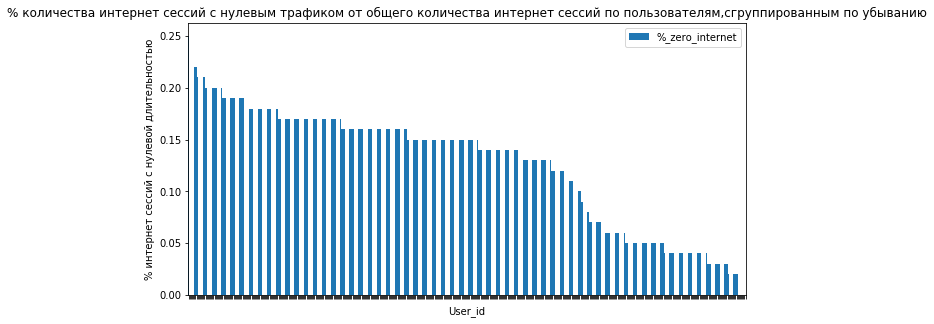

In [12]:
grouped_internet = pd.pivot_table(data_internet, index = 'user_id', values = ['id'], aggfunc = 'count' )
missing_internet = pd.pivot_table(data_internet.query('mb_used == 0'), index = 'user_id', values = 'id', aggfunc = 'count' )
grouped_internet = grouped_internet.join(missing_internet, how = 'outer', rsuffix = '_x')
grouped_internet.columns = ['total_number_of_sessions', 'number_of_zero_internet']
grouped_internet ['%_zero_internet'] = round(grouped_internet['number_of_zero_internet']/ grouped_internet['total_number_of_sessions'],2)
grouped_internet.sort_values('%_zero_internet', ascending = False)
missing_trafic_plot = grouped_internet.sort_values('%_zero_internet', ascending = False).\
plot(title = '% количества интернет сессий с нулевым трафиком от общего количества интернет сессий по пользователям,\
сгруппированным по убыванию',y= '%_zero_internet', kind = 'bar',figsize = (10,5))

missing_trafic_plot.set_xticklabels('')
plt.xlabel('User_id')
plt.ylabel('% интернет сессий с нулевой длительностью')

Процент сессий с 0 значеинем не равномерно распределен. Отвергаем гипотезу, что пропуски образуются из-за округления от работы системных файлов. Оставляеем пропущенные значения, так как не понимаем их природу

#### Изучим data_messages

In [13]:
display(data_messages.head(10))
data_messages.info()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


В файле нет пропусков и подозрительных значений, так как файл содежит только дату и id пользователя

#### Изучим data_users

In [14]:
display(data_users.head(10))
data_users.info()
#display(data_users.groupby('age')['age'].count())

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


В файле 462 пропуска в столбце "дата прекращения пользования", что говорит о том, что только 7,6% пользователей ушли от оператора. Пропущенных значений в столбце с возрастом нет. 

### Вывод

* В файле с количеством звонком были звонки с нулевой длительностью (20% от всех звонков). Процент звонком в нулевой длительностью почти одинаковый для всех пользователей, поэтому природа пропусков - техническая, не связана с действиями пользователей. Удалили данные строки, чтобы расчет средней длительности и медианной был ближе к реальным значениям.
* В файле с использованием интернета были сессии с нулевым использованием. Была гипотеза, что это системные заходы в интернет от программного обеспечения планшентов, телефонов, которые составляют меньше 10 КБ (порог округления). Данная гипотеза не подтвердилась, так как процент таких сессий отличается от пользователя к пользователю. Решил оставить эти значения, так как не понятна их природа.
* В файле с количеством сообщений не выявлено пропусков или подозрительных значений.

### 2. Объединение файлов. <a class="anchor" id="2-bullet"></a>

Сдеаем объединенную таблицу, содержащюю информацию по длительности звонков, количетсву сообщений, использованию интернета и информации по пользователям для каждого пользователя по месяцам для дальнейшего анализа, так как тарифы расчитываются на месяц. 
Для объединения таблиц сгрупируем все таблицы data_calls, data_messages, data_internet по пользователю и месяцу

Округлим длительность звонков вверх, согласно методики оператора

In [15]:
#data_calls['duration'] = round(data_calls['duration'] + 0.5, 0)

# Обновленное решение
data_calls['duration'] = data_calls['duration'].apply(np.ceil) 
#data_calls

Сначала объединим таблицы data_calls и data_users и сделаем сводный таблицу для дальнейшего объединения

In [16]:
data_jointed = data_calls

data_jointed = data_jointed.merge(data_users, on='user_id', how = 'outer') 
calls_grouped = pd.pivot_table(data_jointed, index = ['user_id','age','tariff','city','month'], values ='duration', aggfunc = 'sum')
calls_grouped
display(calls_grouped.query('user_id == 1328'))

,,,,,duration
user_id,age,tariff,city,month,


Сгруппируем таблицы data_internet и data_messages сначала также с data_user, чтобы не потерять пользователей, которые не испольовали сообщения/звонки/интернет. Если таблицы сначала объединить с data_users, а потом между собой, то не будет потери пользователей и остальных данных

In [17]:
data_internet

,Unnamed: 0,id,mb_used,session_date,user_id,month
0,0,1000_0,112.95,2018-11-25,1000,11
1,1,1000_1,1052.81,2018-09-07,1000,9
2,2,1000_2,1197.26,2018-06-25,1000,6
3,3,1000_3,550.27,2018-08-22,1000,8
4,4,1000_4,302.56,2018-09-24,1000,9
...,...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499,10
149392,149392,1499_153,490.13,2018-12-14,1499,12
149393,149393,1499_154,0.00,2018-10-27,1499,10
149394,149394,1499_155,1246.32,2018-11-26,1499,11


In [18]:
# Сгруппируем таблицу с количеством сообщений
data_internet['session_date'] = pd.to_datetime(data_internet['session_date'], format = '%Y-%m-%d')
data_internet['month'] = data_internet['session_date'].dt.month
internet_jointed = data_internet.merge(data_users, on='user_id', how = 'outer') 
internet_grouped = pd.pivot_table(internet_jointed, index = ['user_id','age','tariff','city','month'], values ='mb_used', aggfunc = 'sum')
internet_grouped.columns = ['mb_used']
display(internet_grouped.head(15))

mb_used
user_id age tariff city        month          
1000    52  ultra  Краснодар   5.0     2253.49
                               6.0    23233.77
                               7.0    14003.64
                               8.0    14055.93
                               9.0    14568.91
                               10.0   14702.49
                               11.0   14756.47
                               12.0    9817.61
1001    41  smart  Москва      11.0   18429.34
                               12.0   14036.66
1002    59  smart  Стерлитамак 6.0    10856.82
                               7.0    17580.10
                               8.0    20319.26
                               9.0    16691.08
                               10.0   13888.25

Добавим столбец с использованными ГБ, округлим вверх за месяц. Добавим округленные данные обратно в столбец mb_used

In [19]:
#internet_grouped['gb_used'] = round(internet_grouped['mb_used'] / 1024 + 0.5,0)  

#Обновленное решение
internet_grouped['gb_used'] = (internet_grouped['mb_used'] / 1024).apply(np.ceil)
internet_grouped['mb_used'] = internet_grouped['gb_used'] * 1024 
del internet_grouped['gb_used']

In [20]:
# Сгруппируем таблицу с количеством сообщений
data_messages['message_date'] = pd.to_datetime(data_messages['message_date'], format = '%Y-%m-%d')
data_messages['month'] = data_messages['message_date'].dt.month
messages_jointed = data_messages.merge(data_users, on='user_id', how = 'outer') 
messages_grouped = pd.pivot_table(messages_jointed, index = ['user_id','age','tariff','city','month'], values ='message_date', aggfunc = 'count')
messages_grouped.columns = ['message_number']
#display(messages_grouped.head(15))


Затем объединим 3 таблицы в одну

In [21]:
usage_data = calls_grouped
usage_data = usage_data.join(internet_grouped, how = 'outer')
usage_data = usage_data.join(messages_grouped, how = 'outer')
display(usage_data.head(10))

duration  mb_used  message_number
user_id age tariff city      month                                   
1000    52  ultra  Краснодар 5.0       159.0   3072.0            22.0
                             6.0       172.0  23552.0            60.0
                             7.0       340.0  14336.0            75.0
                             8.0       408.0  14336.0            81.0
                             9.0       466.0  15360.0            57.0
                             10.0      350.0  15360.0            73.0
                             11.0      338.0  15360.0            58.0
                             12.0      333.0  10240.0            70.0
1001    41  smart  Москва    11.0      430.0  18432.0             NaN
                             12.0      414.0  14336.0             NaN

* Заполним пропуски в количестве сообщений нулями
* Пропуски в количестве сообщений возникли после объединения таблиц из-за того, что абоненты не отправляли сообщения в часть месяцев, когда пользовались другими услугами (связь, интернет)

In [22]:
usage_data = usage_data.fillna(0)
usage_data

duration  mb_used  message_number
user_id age tariff city        month                                   
1000    52  ultra  Краснодар   5.0       159.0   3072.0            22.0
                               6.0       172.0  23552.0            60.0
                               7.0       340.0  14336.0            75.0
                               8.0       408.0  14336.0            81.0
                               9.0       466.0  15360.0            57.0
...                                        ...      ...             ...
1498    68  smart  Владикавказ 10.0      247.0  21504.0            42.0
1499    35  smart  Пермь       9.0        70.0   2048.0            11.0
                               10.0      449.0  18432.0            48.0
                               11.0      612.0  18432.0            59.0
                               12.0      492.0  13312.0            66.0

[3214 rows x 3 columns]

### Вывод

Объединил 4 таблицы в одну и сделал сводную таблицу для удобства анализа, сгруппированную по пользователям и месяцу. В качестве значений - тариф, возраст, город, длительность звонков, использование МБ интернета, количество сообщений

### 3. Расчет значений <a class="anchor" id="3-bullet"></a>

Добавим в объединенную таблицу разницу в длительности звонков, МБ интернета и количестве сообщений пользователей относительно тарифов.

In [23]:
usage_data
#usage_data.loc[usage_data.query('tariff == "smart"').index, 'md_used']

duration  mb_used  message_number
user_id age tariff city        month                                   
1000    52  ultra  Краснодар   5.0       159.0   3072.0            22.0
                               6.0       172.0  23552.0            60.0
                               7.0       340.0  14336.0            75.0
                               8.0       408.0  14336.0            81.0
                               9.0       466.0  15360.0            57.0
...                                        ...      ...             ...
1498    68  smart  Владикавказ 10.0      247.0  21504.0            42.0
1499    35  smart  Пермь       9.0        70.0   2048.0            11.0
                               10.0      449.0  18432.0            48.0
                               11.0      612.0  18432.0            59.0
                               12.0      492.0  13312.0            66.0

[3214 rows x 3 columns]

In [24]:
# Функция для заполнения разницы параметра 
def dif (parametr, name_col, tarif):
    parametr_smart = float(data_tariffs.query('tariff_name == "smart"')[tarif])
    parametr_ultra = float(data_tariffs.query('tariff_name == "ultra"')[tarif])   
    usage_data.loc[usage_data.query('tariff == "smart"').index, name_col] =\
    usage_data.loc[usage_data.query('tariff == "smart"').index, parametr] - parametr_smart
    usage_data.loc[usage_data.query('tariff == "ultra"').index, name_col] =\
    usage_data.loc[usage_data.query('tariff == "ultra"').index, parametr] - parametr_ultra

# Добавим разницу по длительности звонков
dif('duration','calls_dif', 'minutes_included')

# Добавим разницу по интернет трафику
dif('mb_used','internet_dif','mb_per_month_included')

# Добавим разницу по количеству сообщений
dif('message_number','message_dif','messages_included')

display(usage_data)

duration  mb_used  message_number  \
user_id age tariff city        month                                      
1000    52  ultra  Краснодар   5.0       159.0   3072.0            22.0   
                               6.0       172.0  23552.0            60.0   
                               7.0       340.0  14336.0            75.0   
                               8.0       408.0  14336.0            81.0   
                               9.0       466.0  15360.0            57.0   
...                                        ...      ...             ...   
1498    68  smart  Владикавказ 10.0      247.0  21504.0            42.0   
1499    35  smart  Пермь       9.0        70.0   2048.0            11.0   
                               10.0      449.0  18432.0            48.0   
                               11.0      612.0  18432.0            59.0   
                               12.0      492.0  13312.0            66.0   

                                      calls_dif  internet_dif  message_dif  
user_id age tariff city        month                                        
1000    52  ultra  Краснодар   5.0      -2841.0      -27648.0       -978.0  
                               6.0      -2828.0       -7168.0       -940.0  
                               7.0      -2660.0      -16384.0       -925.0  
                               8.0      -2592.0      -16384.0       -919.0  
                               9.0      -2534.0      -15360.0       -943.0  
...                                         ...           ...          ...  
1498    68  smart  Владикавказ 10.0      -253.0        6144.0         -8.0  
1499    35  smart  Пермь       9.0       -430.0      -13312.0        -39.0  
                               10.0       -51.0        3072.0         -2.0  
                               11.0       112.0        3072.0          9.0  
                               12.0        -8.0       -2048.0         16.0  

[3214 rows x 6 columns]

Расчитаем выручку в новом столбце revenue

In [25]:
# Оставим в столбцах с разницей только положительную
usage_data.loc[usage_data.query('internet_dif < 0').index,'internet_dif'] = 0
usage_data.loc[usage_data.query('message_dif < 0').index,'message_dif'] = 0
usage_data.loc[usage_data.query('calls_dif < 0').index,'calls_dif'] = 0                               

# Функция для расчета выручки тарифа 
def tarif_revenue (tarif):
    fee = float(data_tariffs.query('tariff_name == @tarif')['rub_monthly_fee'])
    internet_fee_gb = float(data_tariffs.query('tariff_name == @tarif')['rub_per_gb']) 
    message_fee = float(data_tariffs.query('tariff_name == @tarif')['rub_per_message']) 
    call_fee = float(data_tariffs.query('tariff_name == @tarif')['rub_per_minute'])  
    internet_dif_gb = round(usage_data.loc[usage_data.query('tariff == @tarif').index, 'internet_dif']/1024 + 0.5,0)
    message_dif = usage_data.loc[usage_data.query('tariff == @tarif').index, 'message_dif']
    call_dif = usage_data.loc[usage_data.query('tariff == @tarif').index, 'calls_dif'] 
    usage_data.loc[usage_data.query('tariff == @tarif').index, 'revenue'] =\
    round(fee + internet_dif_gb * internet_fee_gb  + call_fee * call_dif + message_fee * message_dif,0)

tarif_revenue ('smart')
tarif_revenue ('ultra')
display(usage_data)

duration  mb_used  message_number  \
user_id age tariff city        month                                      
1000    52  ultra  Краснодар   5.0       159.0   3072.0            22.0   
                               6.0       172.0  23552.0            60.0   
                               7.0       340.0  14336.0            75.0   
                               8.0       408.0  14336.0            81.0   
                               9.0       466.0  15360.0            57.0   
...                                        ...      ...             ...   
1498    68  smart  Владикавказ 10.0      247.0  21504.0            42.0   
1499    35  smart  Пермь       9.0        70.0   2048.0            11.0   
                               10.0      449.0  18432.0            48.0   
                               11.0      612.0  18432.0            59.0   
                               12.0      492.0  13312.0            66.0   

                                      calls_dif  internet_dif  message_dif  \
user_id age tariff city        month                                         
1000    52  ultra  Краснодар   5.0          0.0           0.0          0.0   
                               6.0          0.0           0.0          0.0   
                               7.0          0.0           0.0          0.0   
                               8.0          0.0           0.0          0.0   
                               9.0          0.0           0.0          0.0   
...                                         ...           ...          ...   
1498    68  smart  Владикавказ 10.0         0.0        6144.0          0.0   
1499    35  smart  Пермь       9.0          0.0           0.0          0.0   
                               10.0         0.0        3072.0          0.0   
                               11.0       112.0        3072.0          9.0   
                               12.0         0.0           0.0         16.0   

                                      revenue  
user_id age tariff city        month           
1000    52  ultra  Краснодар   5.0     1950.0  
                               6.0     1950.0  
                               7.0     1950.0  
                               8.0     1950.0  
                               9.0     1950.0  
...                                       ...  
1498    68  smart  Владикавказ 10.0    1750.0  
1499    35  smart  Пермь       9.0      550.0  
                               10.0    1350.0  
                               11.0    1713.0  
                               12.0     598.0  

[3214 rows x 7 columns]

### Вывод

* Округлил длительность звонков в большую сторону согласно тарифу
* Расчитал превышение минут, сообщений, интернета для каждого пользователя помесячно
* Расчтал помесячную выручку с каждого пользователя

### 4. Визуализация. <a class="anchor" id="4-bullet"></a>

Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

Напишем функцию для построения графика распределения</font>

In [26]:
def distribution(parametr, name):
    print('Среднее - ', name ,round(usage_data[parametr].mean(),0))
    print('Медианна - ',name,round(usage_data[parametr].median(),0))
    print('Среднее отклонение - ', name, round(np.std(usage_data[parametr]),0))
    print('Дисперсия - ', name, round(np.var(usage_data[parametr], ddof=1),0))
    print('Распределение -', name)
    sns.distplot(usage_data[parametr])

Посчитаем статистику для длительности звонков

Среднее -  длительность звонка 451.0
Медианна -  длительность звонка 443.0
Среднее отклонение -  длительность звонка 242.0
Дисперсия -  длительность звонка 58520.0
Распределение - длительность звонка


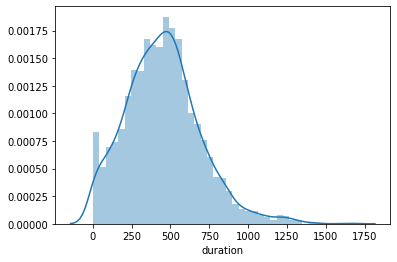

In [27]:
distribution('duration', 'длительность звонка')

In [28]:
#print('Средняя длительность звонка',round(usage_data['duration'].mean(),0))
#print('Медианна длительность звонка',round(usage_data['duration'].median(),0))
#print('Среднее отклонение длительности звонка', round(np.std(usage_data['duration']),0))
#print('Дисперсия длительности звонка', round(np.var(usage_data['duration'], ddof=1),0))
#print('Распределение длительности звонков')
#sns.distplot(usage_data['duration'])

Распределние немного смещено вправо, но похоже на нормальное. Это неудивительно, что так как длительность звонков, которые делает каждый человек не должно сильно отличаться, в среднем 7 часов в месяц

Посчитаем статистику для интернет трафика

Среднее -  интернет трафик 17714.0
Медианна -  интернет трафик 17408.0
Среднее отклонение -  интернет трафик 7577.0
Дисперсия -  интернет трафик 57429087.0
Распределение - интернет трафик


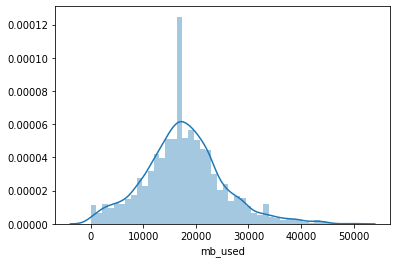

In [29]:
distribution('mb_used', 'интернет трафик')

In [30]:
#print('Средний интернет трафик',round(usage_data['md_used'].mean(),0))
#print('Медианный интернет трафик',round(usage_data['md_used'].median(),0))
#print('Среднее отклонение интернет трафика',  round(np.std(usage_data['md_used']),0))
#print('Дисперсия интернет трафика', round(np.var(usage_data['md_used'], ddof=1),0))
#print('Распределение интернет трафика')
#sns.distplot(usage_data['md_used'])

Использование интернета распредлено нормально. В среднем пользователи использую 17.2 Гб траффика.

Посчитаем статистику для количества сообщений

Среднее -  количество сообщений 38.0
Медианна -  количество сообщений 30.0
Среднее отклонение -  количество сообщений 36.0
Дисперсия -  количество сообщений 1307.0
Распределение - количество сообщений


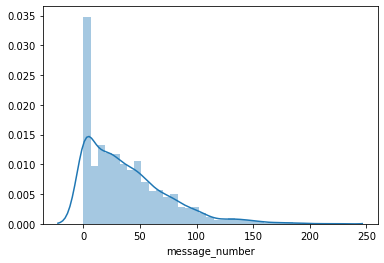

In [31]:
distribution('message_number', 'количество сообщений')

In [32]:
#print('Среднее значение количества сообщений',round(usage_data['message_number'].mean(),0))
#print('Медианное значение количества сообщений',round(usage_data['message_number'].median(),0))
#print('Среднее отклонение количества сообщений',  round(np.std(usage_data['message_number']),0))
#print('Дисперсия количества сообщений', round(np.var(usage_data['message_number'], ddof=1),0))
#print('Распределение Количества сообщений')
#sns.distplot(usage_data['message_number'])

Распределение количеcтва сообщений смещено вправо, так как большинство людей не редко используют сообщения (35% пользователей не используют совсем). В среднем - 38 сообщений в месяц, а медианное значение - 30. Пользователи заменяют соббщения общением через интернет (благо у большинства он есть ^_^)

Посмотрим на распределение выручки по тарифам

Распределение выручки по тарифу "Ультра"
                                          internet_dif  calls_dif  message_dif
user_id age tariff city            month                                      
1124    54  ultra  Махачкала       10.0        19456.0        0.0          0.0
1240    30  ultra  Воронеж         8.0         18432.0        0.0          0.0
1255    40  ultra  Саранск         7.0         15360.0        0.0          0.0
1300    40  ultra  Москва          11.0        14336.0        0.0          0.0
1240    30  ultra  Воронеж         12.0        13312.0        0.0          0.0
...                                                ...        ...          ...
1200    36  ultra  Санкт-Петербург 11.0            0.0        0.0          0.0
                                   12.0            0.0        0.0          0.0
1201    32  ultra  Москва          8.0             0.0        0.0          0.0
                                   9.0             0.0        0.0          0.0
1495    65 

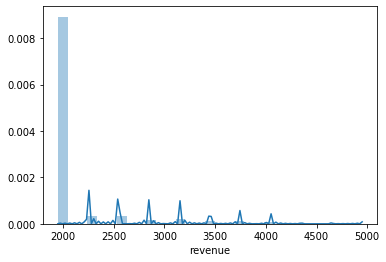

In [33]:
print('Распределение выручки по тарифу "Ультра"')
sns.distplot(usage_data.query('tariff == "ultra"')['revenue'])
print(usage_data.query('tariff == "ultra"')[['internet_dif', 'calls_dif', 'message_dif' ]].\
      sort_values('internet_dif', ascending = False))
print('Среднее превышение интернет трафика на', round(usage_data.query('tariff == "ultra"')['internet_dif'].mean(),0))

Большинство пользователей платят базовую стоиомость за тариф - 1950 рублей в месяц. Выручка выше базовой наблюдается только за счет превышения интернет трафика. Среднее превышение трафика - 0.75 Гб, тогда как есть и превышение на 13-19 Гб

Распределение выручки по тарифу "Smart"
                                          internet_dif  calls_dif  message_dif
user_id age tariff city            month                                      
1486    35  smart  Нижний Новгород 12.0        23552.0      507.0         33.0
1042    42  smart  Хабаровск       12.0        22528.0      228.0         25.0
1098    39  smart  Челябинск       12.0        21504.0       88.0          0.0
1486    35  smart  Нижний Новгород 11.0        21504.0      264.0         46.0
1159    64  smart  Красноярск      12.0        20480.0      234.0          0.0
...                                                ...        ...          ...
1119    53  smart  Петрозаводск    4.0             0.0        0.0          0.0
1118    65  smart  Казань          12.0            0.0      126.0          0.0
                                   11.0            0.0       67.0          0.0
                                   9.0             0.0      266.0          0.0
1499    35  

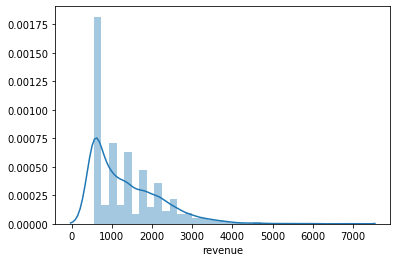

In [34]:
print('Распределение выручки по тарифу "Smart"')
sns.distplot(usage_data.query('tariff == "smart"')['revenue'])
print(usage_data.query('tariff == "smart"')[['internet_dif', 'calls_dif', 'message_dif' ]].\
      sort_values('internet_dif', ascending = False))
print('Среднее превышение интернет трафика на', round(usage_data.query('tariff == "smart"')['internet_dif'].mean(),0))

Аналогично тарифу Ультра, в тарифе Smart самое распространенная плата - 550 рублей (фиксированная плата). Превышение платы наблюдается не только за счет интернет трафика, но и за счет звонков и даже сообщений. Примечательно, что среднее превышение трафика выше чем в тарифе Ультра (2.76 против 0.75).

Построим график выручки по тарифам</font>

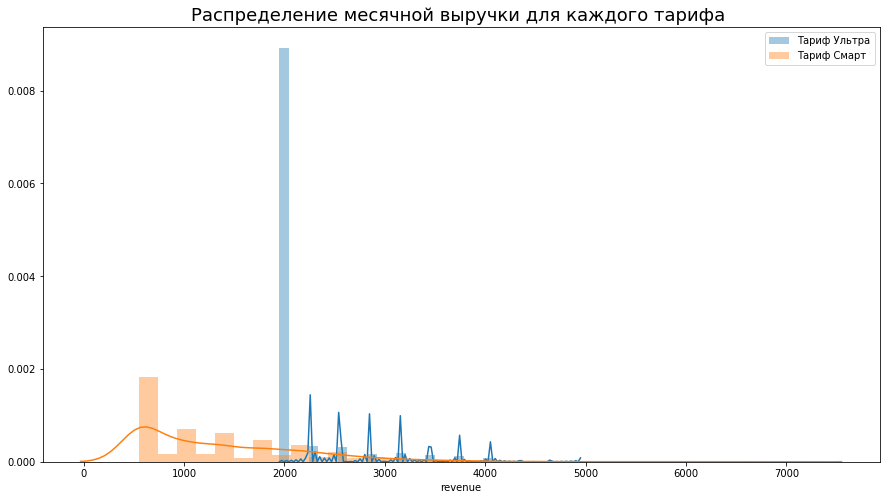

In [35]:
plt.figure(figsize=(15,8))
plt.title('Распределение месячной выручки для каждого тарифа ', fontsize=18)
revenue_ultra = sns.distplot(usage_data.query('tariff == "ultra"')['revenue'], label='Тариф Ультра')
revenue_ultra
plt.legend()
revenue_smart = sns.distplot(usage_data.query('tariff == "smart"')['revenue'], label='Тариф Смарт')
revenue_smart
plt.legend()


### Вывод

* Как и ожидалось, распределение длительности звонков и использования интернета близко к нормальному.
* Распределение колчества соообщений смещенно вправо, так как большинство абонентов не использубт сообщения (заменяют на общение через социальные сети).
* Абоненты в основном платят базовую месячную оплату в обоих тарифах. Превышение в тарифе Ультра полностью объясняется превышеием использования интернета, тогда как в тарифе Smart есть такж превышение в длительности звонков и даже в количестве сообщений. 

### 5. Проверка гипотез. <a class="anchor" id="5-bullet"></a>

Гипотеза 1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается
* Нулевая гипотеза. Средняя выручка пользователей обоих тарифов не отличается
* Альтернативная гипотеза. Средняя выручка пользователей тарифа «Ультра» отличается от выручке в тарифе «Смарт» 

In [36]:
# Выберем 2 критических уровня 1% и 5%
alpha_1 = 0.01
alpha_2 = 0.05

# Проведем тест на равенство дисперсии выборок
# Нулевая гипотеза: дисперсии равны
# Альтернативная гипотез: дисперсии отличаются
smart_revenue = usage_data.query('tariff == "smart"')['revenue']
ultra_revenue = usage_data.query('tariff == "ultra"')['revenue']
test_variance_places = st.levene(smart_revenue, ultra_revenue)
display(test_variance_places)
test_variance_tariffs_pvalue = test_variance_places[1]
if (test_variance_tariffs_pvalue < alpha_1):
    print("Отвергаем нулевую гипотезу на уровне значимости", alpha_1)
else:
    print("Не получилось отвергнуть нулевую гипотезу на уровне значимости",alpha_1)
if (test_variance_tariffs_pvalue < alpha_2):
    print("Отвергаем нулевую гипотезу на уровне значимости", alpha_2)
else:
    print("Не получилось отвергнуть нулевую гипотезу на уровне значимости",alpha_2)

LeveneResult(statistic=641.2589168758196, pvalue=3.790329423164974e-129)

Отвергаем нулевую гипотезу на уровне значимости 0.01
Отвергаем нулевую гипотезу на уровне значимости 0.05


Нет подтверждения равенства дисперсий, поэтому проводим t-test без предпосылки о равенстве

In [41]:
# Выберем 2 критических уровня 1% и 5%
alpha_1 = 0.01
alpha_2 = 0.05

# Проведем t-test

test_1 = st.ttest_ind(smart_revenue,ultra_revenue, equal_var = False)
# Расчитаем p-value
print('p-значение:', test_1.pvalue/2)
# Вывод
if (test_1.pvalue < alpha_1):
    print("Отвергаем нулевую гипотезу на уровне значимости", alpha_1)
else:
    print("Не получилось отвергнуть нулевую гипотезу на уровне значимости",alpha_1)
if (test_1.pvalue < alpha_2):
    print("Отвергаем нулевую гипотезу на уровне значимости", alpha_2)
else:
    print("Не получилось отвергнуть нулевую гипотезу на уровне значимости",alpha_2)

p-значение: 5.791157218356602e-132
Отвергаем нулевую гипотезу на уровне значимости 0.01
Отвергаем нулевую гипотезу на уровне значимости 0.05


Сильные подтверждения (на уровне значимости в 1%) для того,чтобы отвергнуть нулевую гипотезу о равенстве средней выручки по тарифам.

Гипотеза 2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов
* Нулевая гипотеза. Средняя выручка пользователей Москвы и регионов не отличается
* Альтернативная гипотеза. Средняя выручка пользователей Москвы отилчается от регионов

In [38]:
# Выберем 2 критических уровня 1% и 5%
alpha_1 = 0.01
alpha_2 = 0.05

# Разделим города на Москва и другие
usage_data['city_category'] = 'Другие'
usage_data.loc[usage_data.query('city == "Москва"').index,'city_category'] = 'Москва'

# Проведем тест на равенство дисперсии выборок
# Нулевая гипотеза: дисперсии равны
# Альтернативная гипотез: дисперсии отличаются
moscow_revenue = usage_data.query('city_category == "Москва"')['revenue']
other_revenue = usage_data.query('city_category == "Другие"')['revenue']

test_variance_places = st.levene(moscow_revenue, other_revenue)
display(test_variance_places)
test_variance_places_pvalue = test_variance_places[1]
if (test_variance_places_pvalue < alpha_1):
    print("Отвергаем нулевую гипотезу на уровне значимости", alpha_1)
else:
    print("Не получилось отвергнуть нулевую гипотезу на уровне значимости",alpha_1)
if (test_variance_places_pvalue < alpha_2):
    print("Отвергаем нулевую гипотезу на уровне значимости", alpha_2)
else:
    print("Не получилось отвергнуть нулевую гипотезу на уровне значимости",alpha_2)

LeveneResult(statistic=7.094293866466988, pvalue=0.007771585771696081)

Отвергаем нулевую гипотезу на уровне значимости 0.01
Отвергаем нулевую гипотезу на уровне значимости 0.05


Нет подтверждения равенства дисперсий, поэтому проводим t-test без предпосылки о равенстве

In [44]:
# Выберем 2 критических уровня 1% и 5%
alpha_1 = 0.01
alpha_2 = 0.05

# Проведем t-test
test_2 = st.ttest_ind(moscow_revenue,other_revenue, equal_var = False)
# Расчитаем p-value
print('p-значение:', round(test_2.pvalue,2))
# Вывод
if (test_2.pvalue < alpha_1):
    print("Отвергаем нулевую гипотезу на уровне значимости", alpha_1)
else:
    print("Не получилось отвергнуть нулевую гипотезу на уровне значимости",alpha_1)
if (test_2.pvalue < alpha_2):
    print("Отвергаем нулевую гипотезу на уровне значимости", alpha_2)
else:
    print("Не получилось отвергнуть нулевую гипотезу на уровне значимости",alpha_2)

p-значение: 0.69
Не получилось отвергнуть нулевую гипотезу на уровне значимости 0.01
Не получилось отвергнуть нулевую гипотезу на уровне значимости 0.05


Нет подтвержения различия выручки в Москве относительно других городов на уровне значимости 5%

### 6. Общий вывод. <a class="anchor" id="6-bullet"></a>

* В файле присутствовали нулевые значения с длительностью звонка(20%) и интернет трафика(13%). Нулевые значения по длительности присущи всем абонентам, поэтому гипотеза в том, что это технический сбой при выгрузке данных. Удалили строки с нулевой дилтельностью. Количество нулевых значений в интернет трафике отличается от пользователя к пользователю. Поэтому была отвергнута гипотеза, что нулевые значения появляются из-за округления интернет трафика меньше 10 КБ при работе технических служб мобильных телефонов и планшетов.
* Получилось объединить файлы с информацией о пользователях, длительности звноков, использовнии интернета и количества сообщений в одну сводную таблицу. 
* Распределение звонков и использования интерета близко к нормальному, а количества сообщений смещено вправо из-за того, что большинство абонентов не используют сообщения, а предпочитают использовать сообщения через интернет
* Есть сильные подтверждения, чтобы отвергнуть гипотезу о развенстве выручки в обоих тарифах, но нет подтверждений различия выручки в Москве относительно других городов.